In [114]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import *
from sklearn.preprocessing import StandardScaler

# Import libraries
from sklearn import datasets
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import seaborn as sns
%matplotlib inline
import spacy
from nltk import FreqDist
from collections import OrderedDict
import math 

# Load Dataset

In [116]:
# Provided Data
df_train_25tickers = pd.read_csv('../../Predictions/Metalearner/meta_train.csv') 
df_test_25tickers = pd.read_csv('../../Predictions/Metalearner/meta_test.csv') 

X_train = df_train_25tickers.drop('Label', axis=1)
y_train = df_train_25tickers[['Ticker', 'Date', 'Label']]
X_test = df_test_25tickers.drop('Label', axis=1)
y_test = df_test_25tickers[['Ticker', 'Date', 'Label']]



In [117]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print()
print("Feature Columns:", X_train.columns)

X_train: (50325, 17)
y_train: (50325, 3)
X_test: (12575, 17)
y_test: (12575, 3)

X_train_AAPL: (2013, 18)
y_train_AAPL: (2013, 3)
X_test_AAPL: (503, 18)
y_test_AAPL: (503, 3)

Feature Columns: Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'MACD_Hist', 'MACD_Signal', 'RSI', 'Real Lower Band',
       'Real Middle Band', 'Real Upper Band', 'Sector', 'SMA_label'],
      dtype='object')


In [118]:
X_train["BB_diff"] = X_train["Real Upper Band"] - X_train["Real Lower Band"]
X_test["BB_diff"] = X_test["Real Upper Band"] - X_test["Real Lower Band"]

X_train.drop(columns = ["Real Upper Band", "Real Lower Band", "MACD_Hist", "MACD_Signal"], inplace=True)
X_test.drop(columns = ["Real Upper Band", "Real Lower Band", "MACD_Hist", "MACD_Signal"], inplace=True)

In [119]:
from sklearn.preprocessing import StandardScaler
num_cols = ["MACD", "RSI", "Real Middle Band", "SMA_label", "BB_diff"]
tickers = list(X_train.Ticker.unique())
for ticker in tickers:
    sub_train = X_train[X_train.Ticker == ticker].copy()
    sub_test = X_test[X_test.Ticker == ticker].copy()
    for col in num_cols:
        sub_train[col] = sub_train[col].shift(1)
        sub_test[col] = sub_test[col].shift(1)

        X_train.loc[X_train.Ticker == ticker, col] = sub_train[col].values
        X_test.loc[X_test.Ticker == ticker, col] = sub_test[col].values

In [120]:
X_train = X_train.dropna().reset_index().drop('index', axis=1)
X_test = X_test.dropna().reset_index().drop('index', axis=1)
X_train.head()

,Ticker,Date,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,RSI,Real Middle Band,Sector,SMA_label,BB_diff
0,JPM,2010-01-05,0,0.0,-1.0,0.0,1,1,-0.1119,63.0778,41.745,Financials,-1.0,1.8320
1,JPM,2010-01-06,0,0.0,1.0,0.0,1,2,0.0499,69.2038,42.018,Financials,-1.0,2.6728
2,JPM,2010-01-07,0,0.0,-1.0,0.0,1,3,0.1953,70.7624,42.220,Financials,1.0,3.5010
3,JPM,2010-01-08,0,0.0,-1.0,0.0,1,4,0.3763,75.7131,42.505,Financials,1.0,4.6260
4,JPM,2010-01-11,0,0.0,-1.0,0.0,1,0,0.5051,73.9539,42.817,Financials,1.0,5.0972


# Data Reload
To reset your dataframe from source, just run from this cell onwards

In [122]:
df_train_25tickers = X_train.copy()
df_test_25tickers = X_test.copy()
# df_train_AAPL = df_train_AAPL.copy()
# df_test_AAPL = df_test_AAPL.copy()

df_train_25tickers["Label"] = y_train["Label"]
df_test_25tickers["Label"] = y_test["Label"]

# Modelling

In [124]:
df_train_25tickers.corr()

,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,RSI,Real Middle Band,SMA_label,BB_diff,Label
Predictions_8k,1.000000,0.051365,0.098749,0.028448,0.017401,-0.002525,0.024410,0.106914,0.014912,0.106650,0.010984,0.007706
Predictions_10kq,0.051365,1.000000,0.095382,0.024418,0.011761,-0.001209,0.087369,0.193054,-0.008771,0.071836,0.001673,0.027697
Predictions_tweets,0.098749,0.095382,1.000000,0.002067,0.013397,-0.008138,-0.000210,-0.015973,-0.008797,-0.011130,-0.015976,-0.002397
Predictions_news,0.028448,0.024418,0.002067,1.000000,-0.008102,0.017452,0.011787,0.056846,0.011391,0.060804,0.007088,0.023885
Month,0.017401,0.011761,0.013397,-0.008102,1.000000,-0.012576,0.021716,0.022523,0.018432,0.012567,0.004376,-0.001350
Day_of_week,-0.002525,-0.001209,-0.008138,0.017452,-0.012576,1.000000,0.000693,0.002829,-0.000142,0.010704,-0.000800,-0.003953
MACD,0.024410,0.087369,-0.000210,0.011787,0.021716,0.000693,1.000000,0.369717,0.118985,0.060256,-0.388567,0.049538
RSI,0.106914,0.193054,-0.015973,0.056846,0.022523,0.002829,0.369717,1.000000,0.051704,0.523574,-0.054644,0.118993
Real Middle Band,0.014912,-0.008771,-0.008797,0.011391,0.018432,-0.000142,0.118985,0.051704,1.000000,0.001866,0.387975,0.006093
SMA_label,0.106650,0.071836,-0.011130,0.060804,0.012567,0.010704,0.060256,0.523574,0.001866,1.000000,-0.002268,0.037414


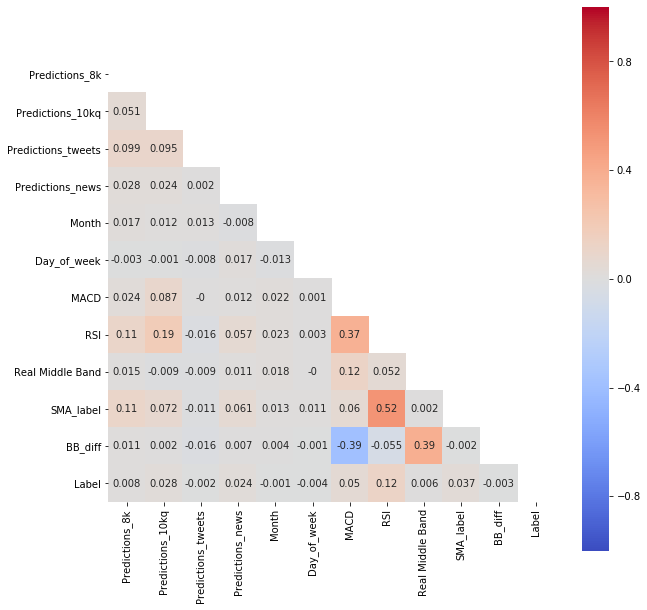

In [126]:
#Deciding which features to include in our predictive churn model,
#Look at the correlations of the features 
corr = round(df_train_25tickers.corr(), 3)
fig, ax = plt.subplots(figsize=(10,10))  
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True, vmin=-1, vmax=1, center= 0, square=True)

In [129]:
df_train_25tickers.columns

Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label', 'BB_diff',
       'Label'],
      dtype='object')

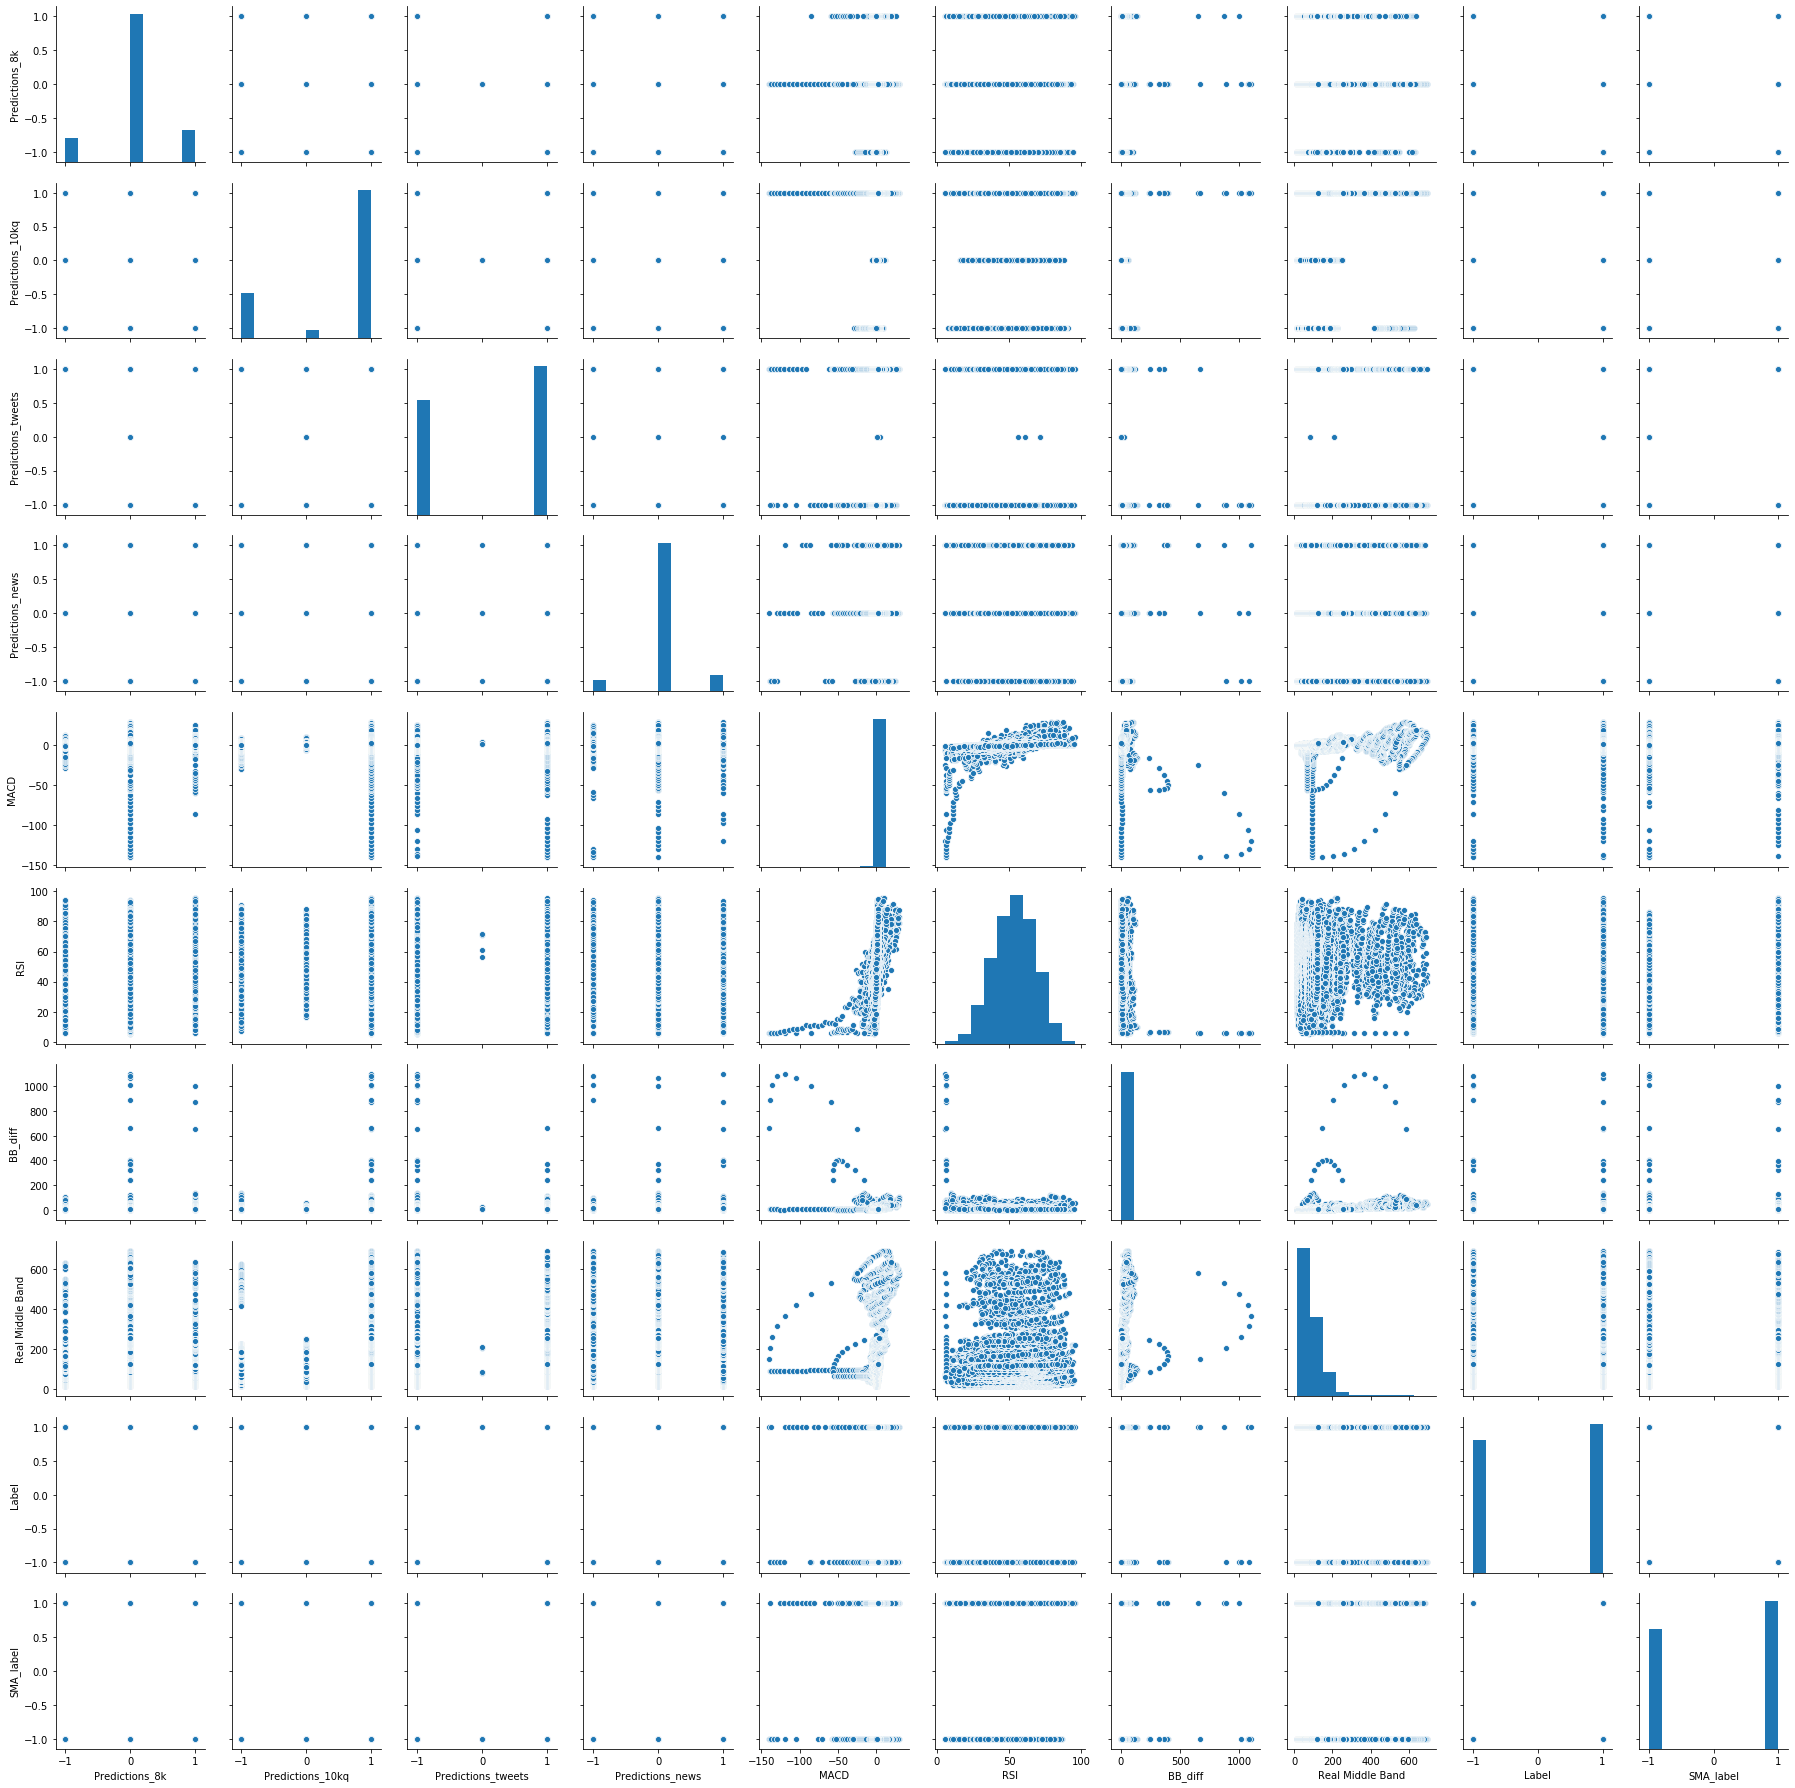

In [130]:
sns.pairplot(df_train_25tickers[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 
       'MACD', 'RSI', 'BB_diff', 'Real Middle Band', 'Label', 'SMA_label']])

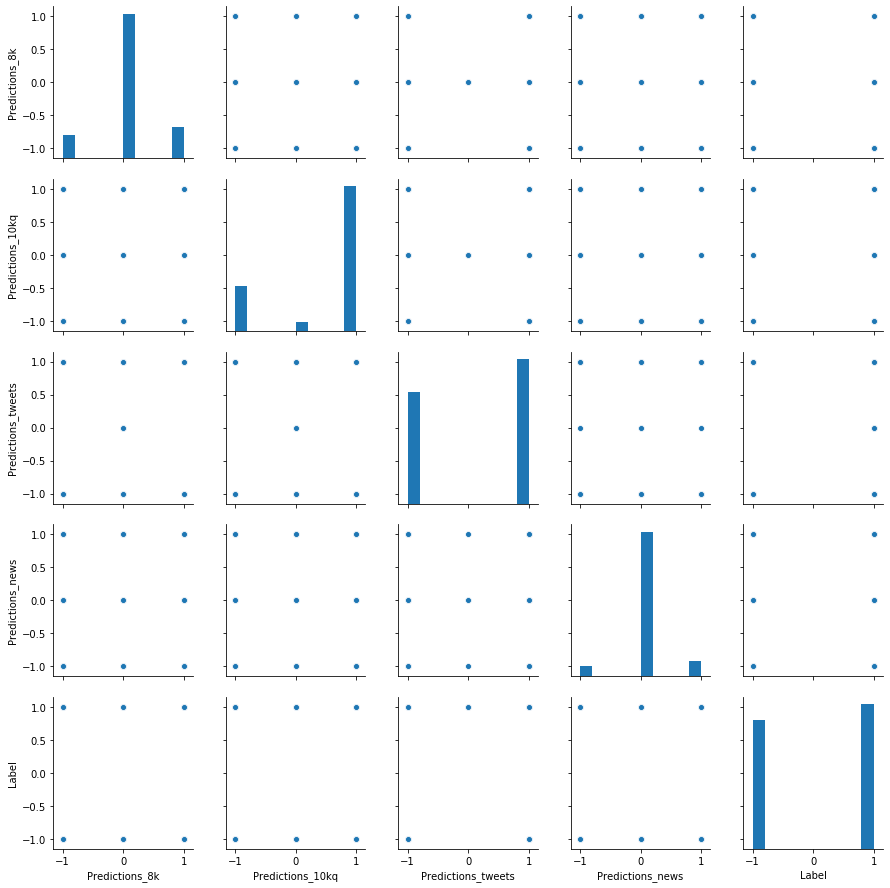

In [131]:
sns.pairplot(df_train_25tickers[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Label']])

# Build 3 different Models to compare Model Performance

1. NLP Model: Only consist of features from the NLP data sources
2. NLP + Technical Indicators Model: Consist both NLP features and the technical indicators
3. NLP + Technical Indicators + Seasonality Model: Consist NLP features, the technical indicators and seasonality

This is to compare how well models will perform with different features

## 1. NLP Model

In [ ]:
new_df_copy = df_train_25tickers.copy()

In [52]:
X_train = new_df_copy[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news']]
X_test = df_test_25tickers[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news']]
y_train = new_df_copy['Label']
y_test = df_test_25tickers['Label']

Random Forest Model

In [53]:
RF_clf =RandomForestClassifier()
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.572141082960755
Test Accuracy:  0.52779324055666
Accuracy:  0.52779324055666
Sensitivity:  0.8281640452741438
Precision:  0.5415745458040949
ROC AUC Score:  0.5009669845220337


XGB Model

In [54]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Accuracy:  0.526520874751491
Accuracy:  0.526520874751491
Sensitivity:  0.8241952079964722
Precision:  0.5409551374819103
ROC AUC Score:  0.4999354418360739


LogReg Model

In [55]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))

Training Accuracy:  0.5718827620466965
Test Accuracy:  0.5250099403578529
Sensitivity:  0.7947964133470528
Precision:  0.5415665064102564
ROC AUC Score:  0.5009151851905049


Adaboost Model

In [56]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.5720019870839543
Test Accuracy:  0.526520874751491
Accuracy:  0.526520874751491
Sensitivity:  0.8241952079964722
Precision:  0.5409551374819103
ROC AUC Score:  0.4999354418360739


## 2. NLP + Technical Indicators Model

In [57]:
df_train_25tickers[['Predictions_8k', 'Predictions_10kq', 'Predictions_tweets', 'Predictions_news',
                    'MACD', 'RSI', 'BB_diff', 'Real Middle Band', 'SMA_label', 'Label']].corr()

,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,MACD,RSI,BB_diff,Real Middle Band,SMA_label,Label
Predictions_8k,1.000000,0.051383,0.098737,0.028451,0.060963,0.147832,0.009760,0.025556,0.148684,0.090922
Predictions_10kq,0.051383,1.000000,0.095449,0.024437,0.186808,0.190056,-0.028994,-0.109086,0.073766,0.040587
Predictions_tweets,0.098737,0.095449,1.000000,0.002078,-0.021040,-0.021598,0.002226,-0.024061,-0.016152,-0.010630
Predictions_news,0.028451,0.024437,0.002078,1.000000,0.027330,0.109121,0.001069,-0.005891,0.129443,0.162672
MACD,0.060963,0.186808,-0.021040,0.027330,1.000000,0.706935,-0.125704,0.239529,0.128223,0.034832
RSI,0.147832,0.190056,-0.021598,0.109121,0.706935,1.000000,-0.068736,0.088620,0.523823,0.320739
BB_diff,0.009760,-0.028994,0.002226,0.001069,-0.125704,-0.068736,1.000000,0.207888,0.005529,0.004812
Real Middle Band,0.025556,-0.109086,-0.024061,-0.005891,0.239529,0.088620,0.207888,1.000000,-0.001562,-0.005672
SMA_label,0.148684,0.073766,-0.016152,0.129443,0.128223,0.523823,0.005529,-0.001562,1.000000,0.376962
Label,0.090922,0.040587,-0.010630,0.162672,0.034832,0.320739,0.004812,-0.005672,0.376962,1.000000


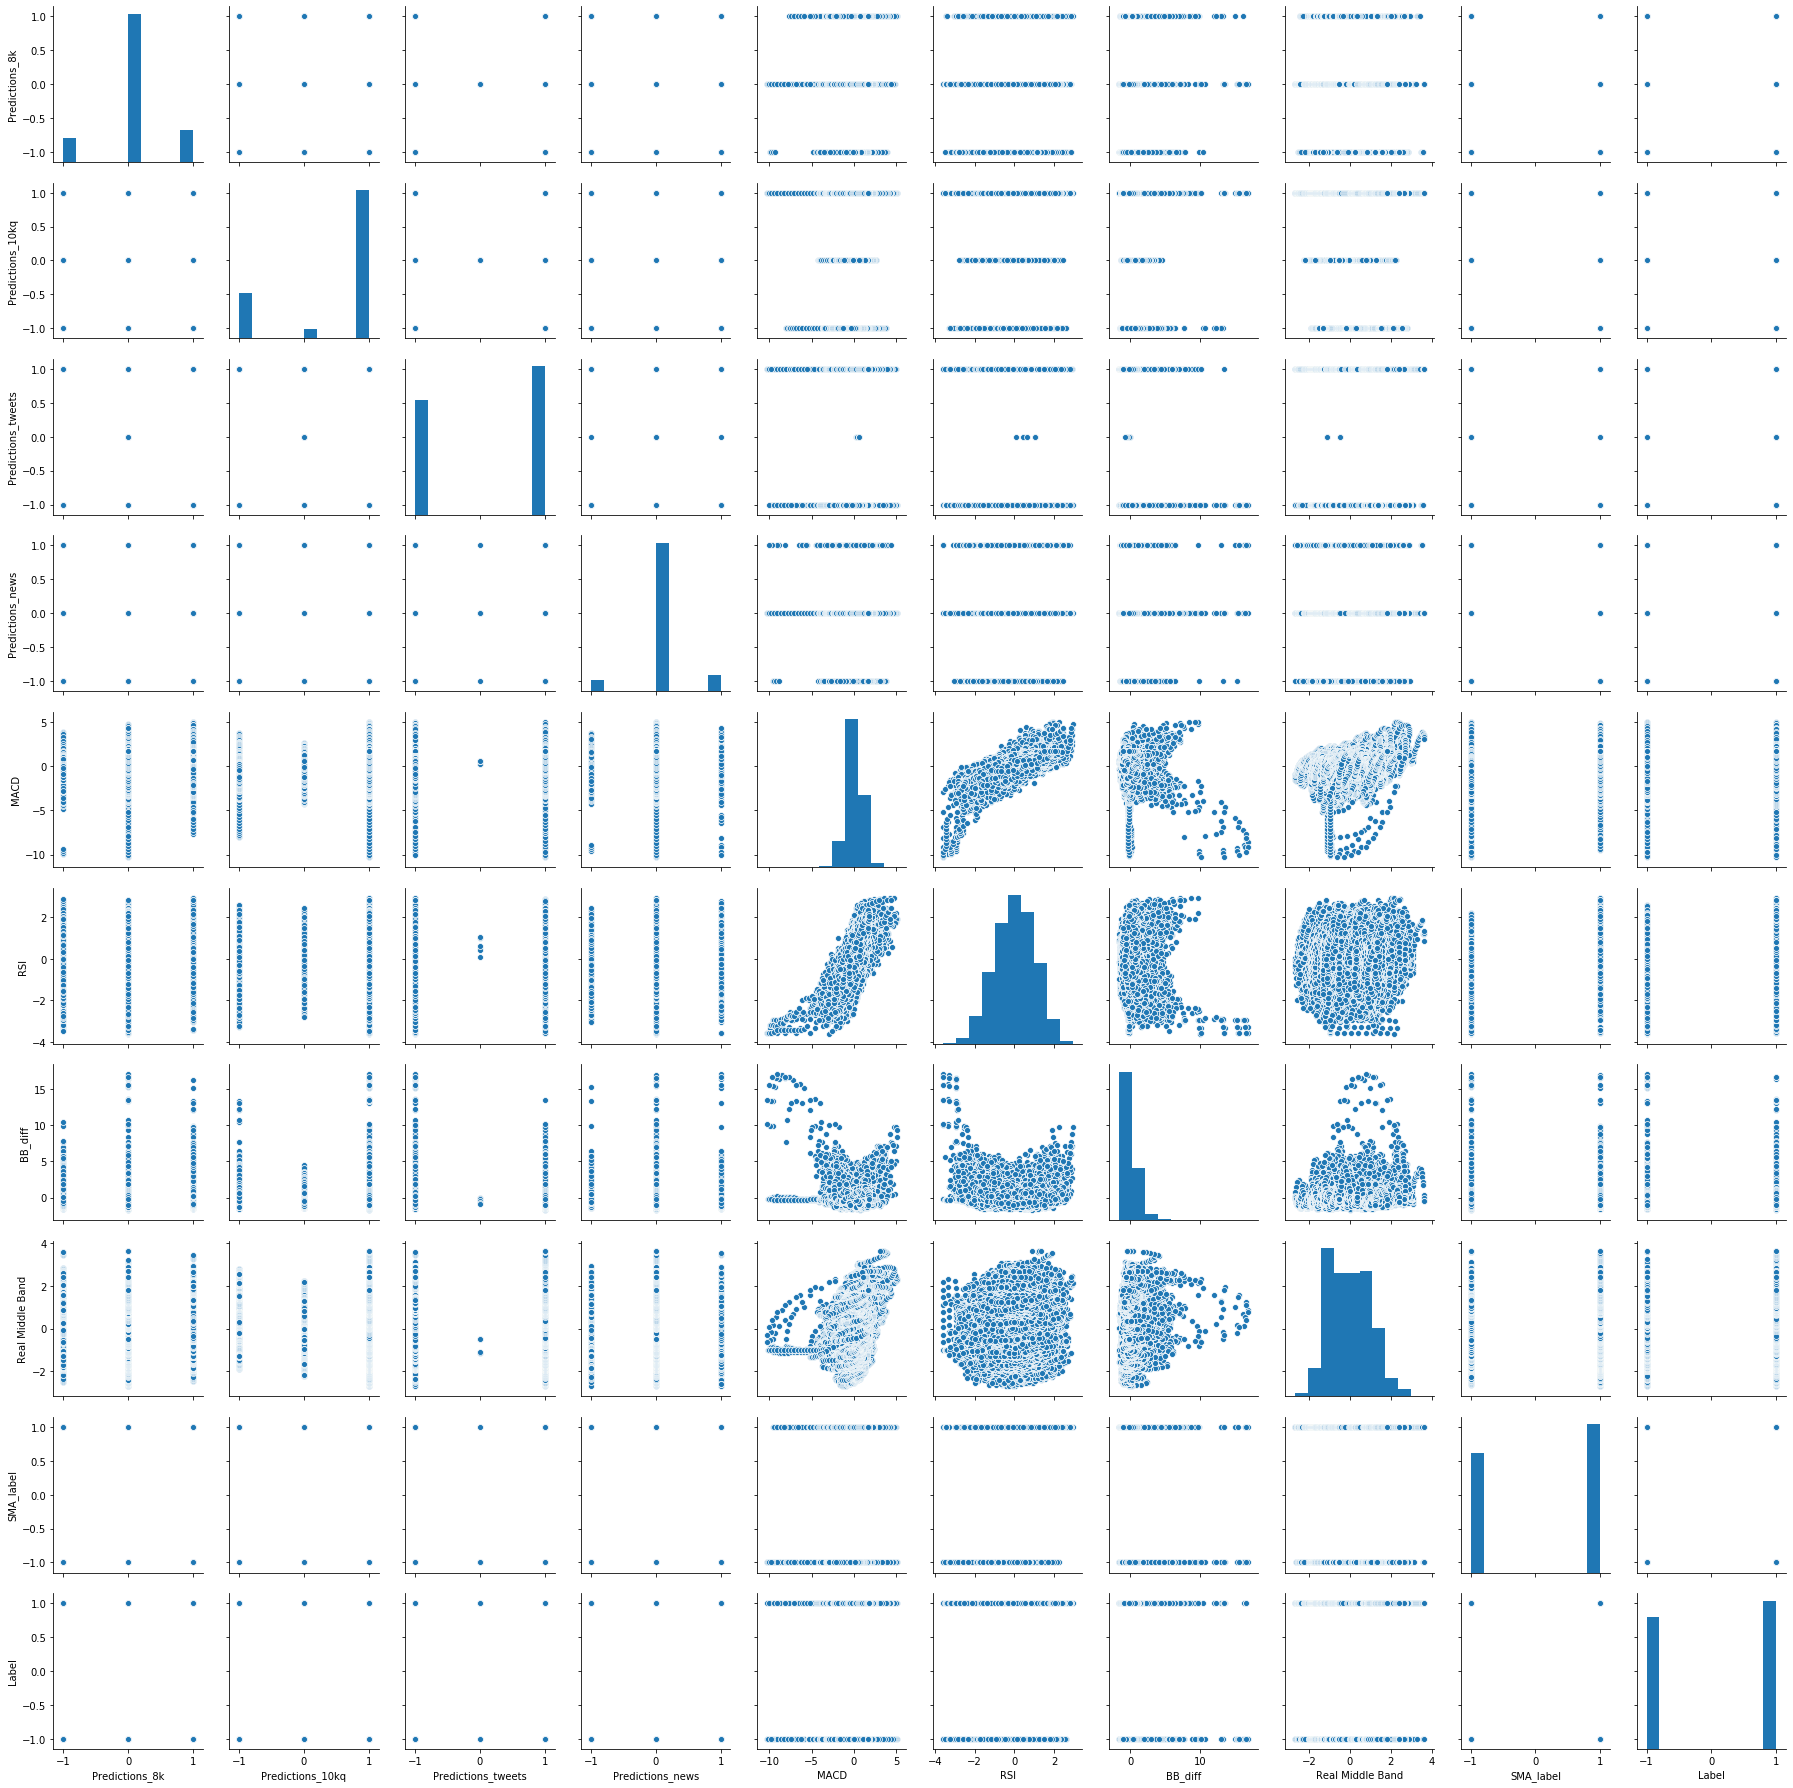

In [58]:
#PAIRPLOT W NLP + TECH IND
sns.pairplot(df_train_25tickers[['Predictions_8k', 'Predictions_10kq', 'Predictions_tweets', 'Predictions_news',
                    'MACD', 'RSI', 'BB_diff', 'Real Middle Band', 'SMA_label', 'Label']])

In [59]:
X_train = new_df_copy[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news','MACD','RSI', 'BB_diff',
       'Real Middle Band', 'SMA_label']]

X_test = df_test_25tickers[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news','MACD','RSI', 'BB_diff',
       'Real Middle Band', 'SMA_label']]

y_train = new_df_copy['Label']
y_test = df_test_25tickers['Label']

In [60]:
X_train

,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,MACD,RSI,BB_diff,Real Middle Band,SMA_label
0,0,0.0,1.0,0.0,-0.378334,0.671160,-0.894245,-0.831682,-1
1,0,0.0,-1.0,0.0,-0.191085,1.110332,-0.467646,-0.815930,-1
2,0,0.0,1.0,0.0,-0.022815,1.222068,-0.047440,-0.804274,1
3,0,0.0,-1.0,0.0,0.186653,1.576983,0.523354,-0.787829,1
4,0,0.0,-1.0,0.0,0.335712,1.450866,0.762427,-0.769826,1
5,0,0.0,-1.0,0.0,0.431998,1.270566,0.869990,-0.754593,1
6,0,0.0,-1.0,0.0,0.403644,0.207370,0.712604,-0.744380,-1
7,0,0.0,-1.0,0.0,0.444149,0.656084,0.464701,-0.728455,-1
8,0,0.0,-1.0,1.0,0.508610,0.882122,0.105482,-0.710221,1
9,-1,0.0,-1.0,-1.0,0.457227,0.039580,-0.594489,-0.698335,1


In [61]:
df_train_25tickers.columns

Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label', 'BB_diff',
       'Label'],
      dtype='object')

In [62]:
RF_clf =RandomForestClassifier(max_depth=15)
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.8159761549925484
Test Accuracy:  0.6534393638170974
Accuracy:  0.6534393638170974
Sensitivity:  0.7277671615463766
Precision:  0.6639399222207322
ROC AUC Score:  0.6468011136907212


In [63]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Accuracy:  0.682624254473161
Accuracy:  0.682624254473161
Sensitivity:  0.7598118477142437
Precision:  0.6868190273717778
ROC AUC Score:  0.6757305946817926


In [64]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))

Training Accuracy:  0.6977247888723298
Test Accuracy:  0.6682306163021868
Sensitivity:  0.7358518300749669
Precision:  0.6782278824007587
ROC AUC Score:  0.6621913343029027


In [65]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.7027918529557874
Test Accuracy:  0.6727634194831014
Accuracy:  0.6727634194831014
Sensitivity:  0.7959723651330295
Precision:  0.6650700073691967
ROC AUC Score:  0.6617595713399035


## 3. NLP + Technical Indicators + Seasonality Model

In [139]:
new_df_copy

,Ticker,Date,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,RSI,Real Middle Band,Sector,SMA_label,BB_diff,Label
0,JPM,2010-01-05,0,0.0,-1.0,0.0,1,1,-0.1119,63.0778,41.745,Financials,-1.0,1.8320,1
1,JPM,2010-01-06,0,0.0,1.0,0.0,1,2,0.0499,69.2038,42.018,Financials,-1.0,2.6728,1
2,JPM,2010-01-07,0,0.0,-1.0,0.0,1,3,0.1953,70.7624,42.220,Financials,1.0,3.5010,1
3,JPM,2010-01-08,0,0.0,-1.0,0.0,1,4,0.3763,75.7131,42.505,Financials,1.0,4.6260,1
4,JPM,2010-01-11,0,0.0,-1.0,0.0,1,0,0.5051,73.9539,42.817,Financials,1.0,5.0972,-1
5,JPM,2010-01-12,0,0.0,-1.0,0.0,1,1,0.5883,71.4389,43.081,Financials,1.0,5.3092,-1
6,JPM,2010-01-13,0,0.0,-1.0,0.0,1,2,0.5638,56.6084,43.258,Financials,-1.0,4.9990,-1
7,JPM,2010-01-14,0,0.0,-1.0,1.0,1,3,0.5988,62.8675,43.534,Financials,-1.0,4.5104,1
8,JPM,2010-01-15,-1,0.0,-1.0,-1.0,1,4,0.6545,66.0205,43.850,Financials,1.0,3.8024,1
9,JPM,2010-01-19,-1,0.0,-1.0,0.0,1,1,0.6101,54.2679,44.056,Financials,1.0,2.4228,-1


In [140]:
new_df_copy = new_df_copy.dropna().reset_index().drop('index', axis=1)
new_df_copy = new_df_copy.dropna().reset_index().drop('index', axis=1)

In [141]:
## Convert Sector to numerical var
new_df_copy["Sector"].value_counts()

Information Technology    12072
Health Care                8048
Industrials                6036
Consumer Staples           6036
Financials                 6036
Consumer Discretionary     6036
Energy                     4024
Communication Services     2012
Name: Sector, dtype: int64

In [142]:
sector_mapping = {"Information Technology": 1, "Health Care":2, "Consumer Staples":3, "Industrials":4, "Financials":5, "Consumer Discretionary": 6,
                  "Energy": 7, "Communication Services":8}
new_df_copy["Sector Map"] = pd.Series(map(lambda x: sector_mapping[x],  new_df_copy["Sector"]))
df_test_25tickers["Sector Map"] = pd.Series(map(lambda x: sector_mapping[x],  df_test_25tickers["Sector"]))

In [143]:
new_df_copy

,Ticker,Date,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,RSI,Real Middle Band,Sector,SMA_label,BB_diff,Label,Sector Map
0,JPM,2010-01-05,0,0.0,-1.0,0.0,1,1,-0.1119,63.0778,41.745,Financials,-1.0,1.8320,1,5
1,JPM,2010-01-06,0,0.0,1.0,0.0,1,2,0.0499,69.2038,42.018,Financials,-1.0,2.6728,1,5
2,JPM,2010-01-07,0,0.0,-1.0,0.0,1,3,0.1953,70.7624,42.220,Financials,1.0,3.5010,1,5
3,JPM,2010-01-08,0,0.0,-1.0,0.0,1,4,0.3763,75.7131,42.505,Financials,1.0,4.6260,1,5
4,JPM,2010-01-11,0,0.0,-1.0,0.0,1,0,0.5051,73.9539,42.817,Financials,1.0,5.0972,-1,5
5,JPM,2010-01-12,0,0.0,-1.0,0.0,1,1,0.5883,71.4389,43.081,Financials,1.0,5.3092,-1,5
6,JPM,2010-01-13,0,0.0,-1.0,0.0,1,2,0.5638,56.6084,43.258,Financials,-1.0,4.9990,-1,5
7,JPM,2010-01-14,0,0.0,-1.0,1.0,1,3,0.5988,62.8675,43.534,Financials,-1.0,4.5104,1,5
8,JPM,2010-01-15,-1,0.0,-1.0,-1.0,1,4,0.6545,66.0205,43.850,Financials,1.0,3.8024,1,5
9,JPM,2010-01-19,-1,0.0,-1.0,0.0,1,1,0.6101,54.2679,44.056,Financials,1.0,2.4228,-1,5


In [144]:
X_train = new_df_copy[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'BB_diff','Real Middle Band', 'SMA_label', "Sector Map"]]

X_test = df_test_25tickers[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'BB_diff','Real Middle Band', 'SMA_label', "Sector Map"]]
       
y_train = new_df_copy['Label']
y_test = df_test_25tickers['Label']

In [145]:
RF_clf =RandomForestClassifier()
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.9829025844930418
Test Accuracy:  0.5144223107569721
Accuracy:  0.5144223107569721
Sensitivity:  0.4584805653710247
Precision:  0.5631103074141048
ROC AUC Score:  0.519445214953661


In [146]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Accuracy:  0.5579282868525897
Accuracy:  0.5579282868525897
Sensitivity:  0.6974381625441696
Precision:  0.5755771567436209
ROC AUC Score:  0.5454019572706954


In [147]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))

Training Accuracy:  0.5561431411530815
Test Accuracy:  0.5543426294820717
Sensitivity:  0.7301236749116607
Precision:  0.5687578850785641
ROC AUC Score:  0.5385595797274524


In [148]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.56220675944334
Test Accuracy:  0.5580876494023904
Accuracy:  0.5580876494023904
Sensitivity:  0.678886925795053
Precision:  0.5781093279839519
ROC AUC Score:  0.5472413093719968


In [149]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                                Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.plot('xlabel', data=feat_imp)
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


'BaggingClassifier' object has no attribute 'feature_importances_'
'LogisticRegression' object has no attribute 'feature_importances_'


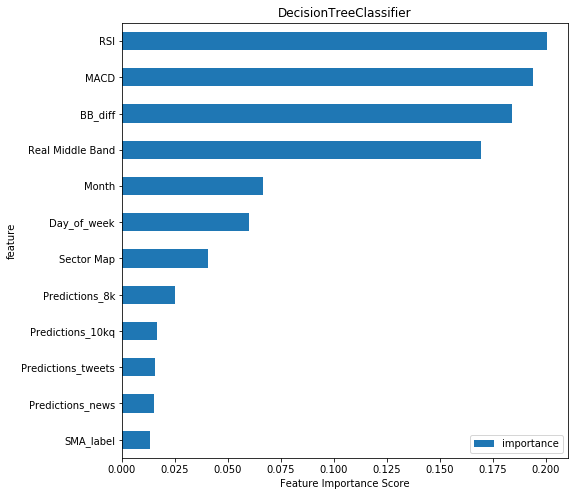

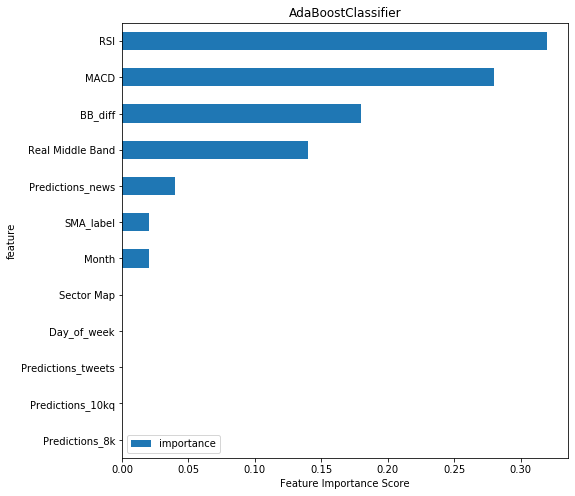

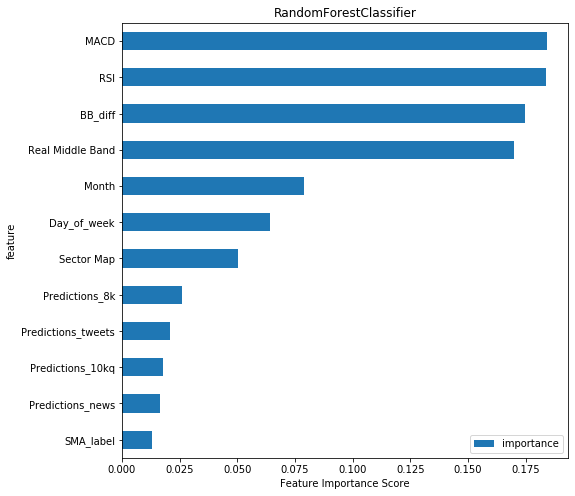

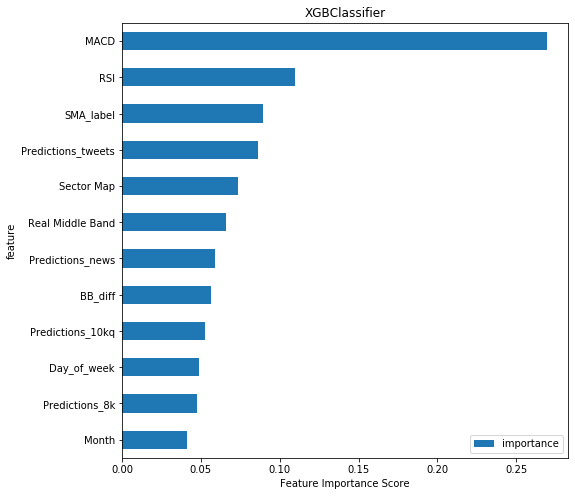

In [150]:
clfs = [BaggingClassifier(),          DecisionTreeClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier(), XGBClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=X_train.shape[1], title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)


In [151]:
X_train

,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,RSI,BB_diff,Real Middle Band,SMA_label,Sector Map
0,0,0.0,-1.0,0.0,1,1,-0.1119,63.0778,1.8320,41.745,-1.0,5
1,0,0.0,1.0,0.0,1,2,0.0499,69.2038,2.6728,42.018,-1.0,5
2,0,0.0,-1.0,0.0,1,3,0.1953,70.7624,3.5010,42.220,1.0,5
3,0,0.0,-1.0,0.0,1,4,0.3763,75.7131,4.6260,42.505,1.0,5
4,0,0.0,-1.0,0.0,1,0,0.5051,73.9539,5.0972,42.817,1.0,5
5,0,0.0,-1.0,0.0,1,1,0.5883,71.4389,5.3092,43.081,1.0,5
6,0,0.0,-1.0,0.0,1,2,0.5638,56.6084,4.9990,43.258,-1.0,5
7,0,0.0,-1.0,1.0,1,3,0.5988,62.8675,4.5104,43.534,-1.0,5
8,-1,0.0,-1.0,-1.0,1,4,0.6545,66.0205,3.8024,43.850,1.0,5
9,-1,0.0,-1.0,0.0,1,1,0.6101,54.2679,2.4228,44.056,1.0,5


### Tuning the Models

#### Fine tune the hyperparameters for Random Forest, Logistic Regression and XGBoost 

#### Tune Random Forest

In [152]:
rf_params = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"], "max_depth": [10, 20], "max_features": ["sqrt", "log2"]}
rf =RandomForestClassifier(random_state=111)

In [153]:
#rf_clf = GridSearchCV(rf, rf_params)
#rf_clf.fit(X_train, y_train)

In [154]:
#rf_clf.best_score_

In [155]:
#rf_clf.best_params_

In [156]:
#sorted(rf_clf.cv_results_.keys())


In [157]:
rf_clf = RandomForestClassifier(random_state=111, criterion="entropy", max_depth=15, max_features = "sqrt", n_estimators=100)
rf_clf.fit(X_train, y_train)
RF_pred = rf_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, rf_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.8296819085487077
Test Accuracy:  0.5455776892430279
Accuracy:  0.5455776892430279
Sensitivity:  0.6903710247349824
Precision:  0.5656894679695983
ROC AUC Score:  0.5325769677339378


#### Tune Logreg Model

In [158]:
logreg_params = {"penalty": ["l1", 'l2'], "fit_intercept": [True, False], "solver": ["saga"], "max_iter": [50, 100, 150]}


In [159]:
lr = LogisticRegression(random_state=111)

In [160]:
# lr_clf = GridSearchCV(lr, logreg_params)
# lr_clf.fit(X_train, y_train)

In [161]:
#lr_clf.best_score_

In [162]:
#lr_clf.best_params_

In [163]:
#sorted(lr_clf.cv_results_.keys())

In [164]:
lr_clf = LogisticRegression(random_state=111, fit_intercept=True, max_iter=50, penalty="l2", solver="saga")
lr_clf.fit(X_train, y_train)

logreg_pred = lr_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, lr_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5478131212723658
Test Accuracy:  0.5555378486055776
Sensitivity:  0.7778268551236749
Precision:  0.5649059024807528
ROC AUC Score:  0.5355789364190795


#### Tune XGB Model

In [165]:
xgb_params = {"max_depth": [50, 100], "min_child_weight": [10, 20], "reg_alpha": [0.01, 0.001], "reg_lamba": [0.01, 0.001]}

In [166]:
xgb = XGBClassifier(random_state=111)

In [167]:
# xgb_clf = GridSearchCV(xgb, xgb_params)
# xgb_clf.fit(X_train, y_train)

In [168]:
#xgb_clf.best_score_

In [169]:
#xgb_clf.best_params_

In [170]:
#sorted(xgb_clf.cv_results_.keys())  

In [171]:
xgb_clf = XGBClassifier(random_state=111, max_depth=50, min_child_weight=20, reg_alpha=0.001, reg_lambda = 0.01)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, xgb_clf.predict(X_train)))
print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training Accuracy:  0.8047912524850894
Test Accuracy:  0.5344223107569721
Accuracy:  0.5344223107569721
Sensitivity:  0.622791519434629
Precision:  0.5631740114498736
ROC AUC Score:  0.5264878055665677


## Ensemble - Combine all 3 models to make predictions more robust

In [172]:
vote_avg = xgb_pred + logreg_pred + RF_pred
vote_avg = vote_avg/3
vote_avg

array([ 1.        ,  0.33333333,  1.        , ...,  0.33333333,
       -0.33333333, -1.        ])

In [173]:
ensemble_pred = pd.Series(map(lambda x: 1 if x>0 else -1, vote_avg))

In [174]:
ensemble_pred

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26      -1
27      -1
28       1
29      -1
        ..
12520   -1
12521   -1
12522   -1
12523   -1
12524    1
12525    1
12526    1
12527   -1
12528   -1
12529    1
12530   -1
12531   -1
12532    1
12533   -1
12534    1
12535   -1
12536   -1
12537   -1
12538   -1
12539   -1
12540    1
12541    1
12542    1
12543   -1
12544    1
12545    1
12546    1
12547    1
12548   -1
12549   -1
Length: 12550, dtype: int64

In [182]:
## Check accuracy
print('Test Accuracy: ', accuracy_score(y_test, ensemble_pred))
print ("Accuracy: ", accuracy_score(y_test,ensemble_pred))
print ("Sensitivity: ", recall_score(y_test, ensemble_pred))
print ("Precision: ", precision_score(y_test, ensemble_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, ensemble_pred))
print("F1 Score:", f1_score(y_test, ensemble_pred))

Test Accuracy:  0.5488446215139442
Accuracy:  0.5488446215139442
Sensitivity:  0.7152532391048292
Precision:  0.5658047985092011
ROC AUC Score:  0.5339031044430016
F1 Score: 0.6318116790219794


### Visualizations

In [57]:
classifier_names = ["RandomForest","LogisticRegression","XGB"]
classifiers = [rf_clf, lr_clf, xgb_clf]
results = dict()
for i,classifier in enumerate(classifiers):
  y_pred = classifier.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test,y_pred)
  metrics =  {"accuracy": acc, "recall_score": recall, "precision": precision, "f1_score":f1}
  results[classifier_names[i]] = metrics

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


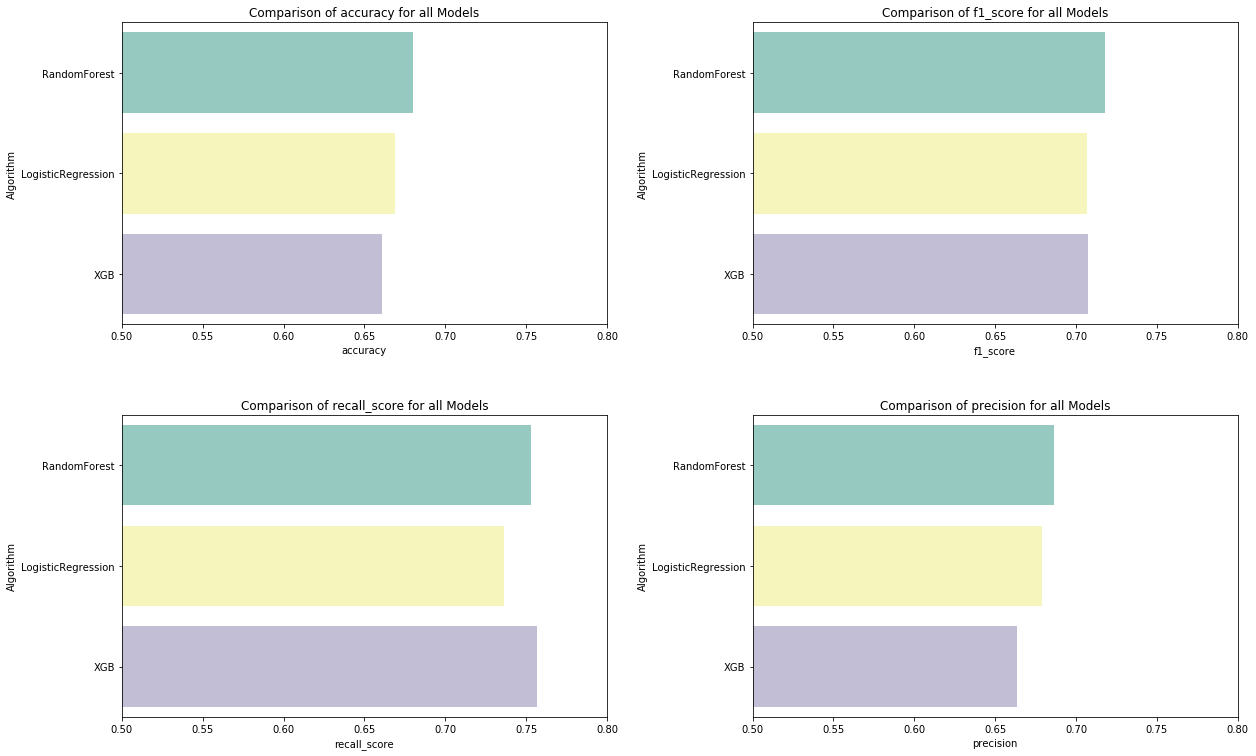

In [58]:
metrics = ["accuracy","f1_score","recall_score","precision"]

model_score_by_metric = []

for i in metrics:
    sub = []
    for j in classifier_names:
        sub.append(results[j][i])
    model_score_by_metric.append(sub)


fig = plt.figure(constrained_layout=False, figsize=(20,20))
spec = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.3)

for i,met in enumerate(metrics):
    #print(met)
    res = pd.DataFrame({"CrossValScore":model_score_by_metric[i],"Algorithm":classifier_names})
    #print(cv_res)
    
    axes = fig.add_subplot(spec[i])

    g = sns.barplot("CrossValScore","Algorithm",data = res, palette="Set3",orient = "h")
    g.set_xlabel(met)
    if met == "accuracy":
        g.set_xlim(0.5, 0.8)
    elif met == "f1_score":
        g.set_xlim(0.5, 0.8)
    elif met == "recall_score":
        g.set_xlim(0.5, 0.8)
    else:
        g.set_xlim(0.5,0.8)
    g = g.set_title(f"Comparison of {met} for all Models")

In [59]:
fig.add_gridspec(3, 2, wspace=0.3, hspace=0.3)

GridSpec(3, 2)

'BaggingClassifier' object has no attribute 'feature_importances_'
'LogisticRegression' object has no attribute 'feature_importances_'


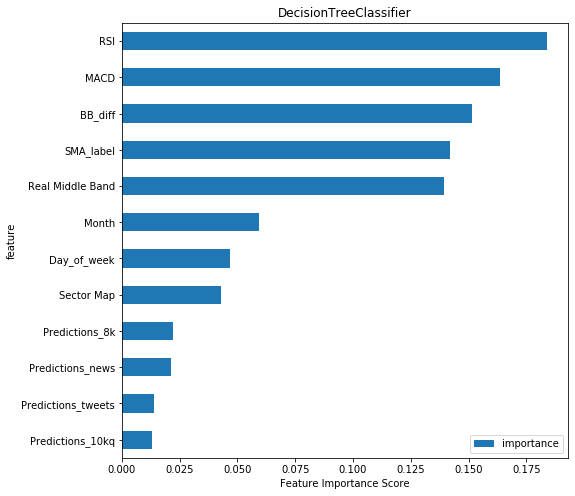

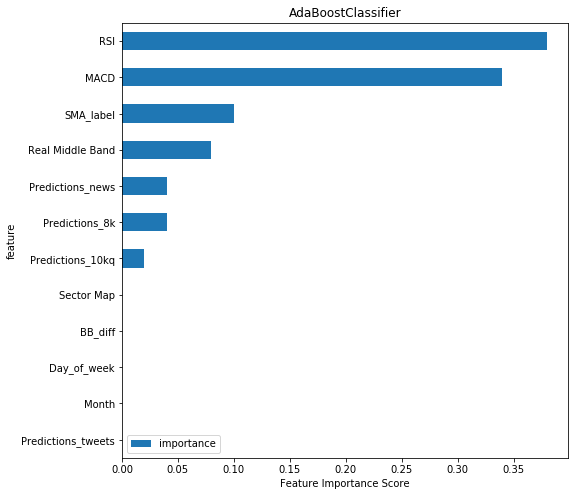

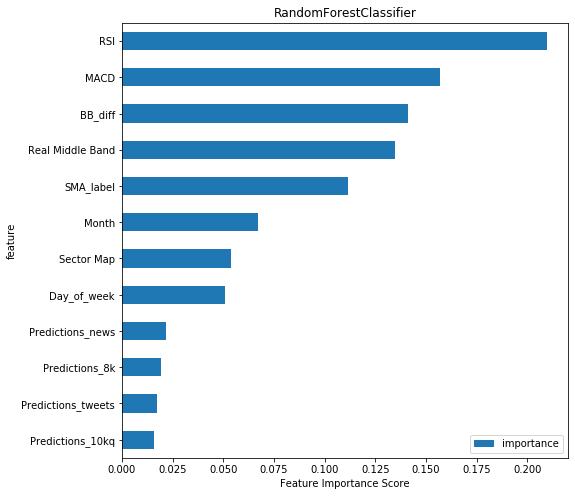

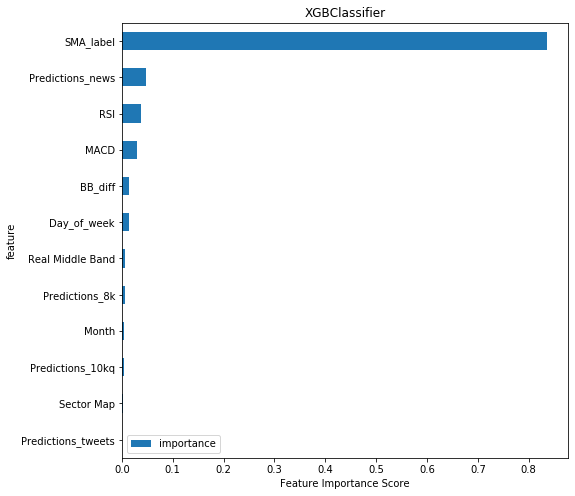

In [60]:
clfs = [BaggingClassifier(),          DecisionTreeClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier(), XGBClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=X_train.shape[1], title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)


In [176]:
#Standardize X values and get the coefficients of Log Reg model
LogReg_clf.fit(X_train / np.std(X_train, 0), y_train)
print(LogReg_clf.coef_)

[[-0.00751202  0.0071712  -0.00107531  0.03738973 -0.00811758 -0.00893155
   0.01301662  0.27160886  0.01742491 -0.00956503 -0.06887447  0.00331101]]


In [177]:
lr_feature_importance = pd.concat([pd.DataFrame(X_train.columns, columns=["feature"]),pd.DataFrame(np.transpose(LogReg_clf.coef_), columns=["coefficient"])], axis = 1)
lr_feature_importance.sort_values(by="coefficient", inplace=True, ascending=True)
lr_feature_importance.reset_index(inplace=True, drop=True)

In [178]:
lr_feature_importance

,feature,coefficient
0,SMA_label,-0.068874
1,Real Middle Band,-0.009565
2,Day_of_week,-0.008932
3,Month,-0.008118
4,Predictions_8k,-0.007512
5,Predictions_tweets,-0.001075
6,Sector Map,0.003311
7,Predictions_10kq,0.007171
8,MACD,0.013017
9,BB_diff,0.017425


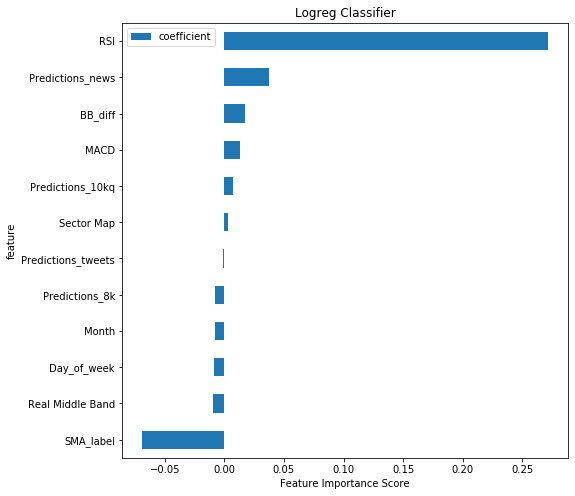

In [179]:
lr_feature_importance = lr_feature_importance.set_index('feature', drop=True)
lr_feature_importance.plot.barh(title="Logreg Classifier", figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.plot('xlabel', data=lr_feature_importance)

In [65]:
import inspect
print(inspect.getsource(plot_feature_importances))

def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
           

In [ ]:
df_test_25tickers["ensemble_pred"] = ensemble_pred
df_test_25tickers["xgb_pred"] = xgb_pred
df_test_25tickers["logreg_pred"] = logreg_pred
df_test_25tickers["RF_pred"] = RF_pred

In [ ]:
df_test_25tickers.to_csv("../../Predictions/Metalearner/25_tickers_prediction.csv", index=False)